# Prereq
This notebook was developed on RAPIDS 21.08. Please use conda env or container from https://rapids.ai/start.html#get-rapids

# Setup
Please execute the following cell the first time to install packages and download data.

In [ ]:
#!pip install biopython
#!wget https://zenodo.org/record/2543724/files/pubchem.chembl.dataset4publication_inchi_smiles_v2.tsv.xz?download=1 -O pubchem.chembl.dataset4publication_inchi_smiles_v2.tsv.xz

In [1]:
import cudf
from Bio import Entrez
from Bio.Entrez.Parser import ListElement
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def get_ec_num(rec):
    """
    Helper function to extract EC number from record
    """
    ecs = []

    if isinstance(rec, ListElement):
        for r in rec:
            ecs.extend(get_ec_num(r))
    elif 'Gene-commentary_label' in rec and rec['Gene-commentary_label'] == 'EC':
        ecs.append(rec['Gene-commentary_text'])
    elif 'Gene-commentary_comment' in rec:
        ecs.extend(get_ec_num(rec['Gene-commentary_comment']))
    elif 'Gene-commentary_products' in rec:
        ecs.extend(get_ec_num(rec['Gene-commentary_products']))

    return ecs

In [4]:
# Load data. Here only required fields are loaded. Please use the wget command 
# in the first cell to download data. Please extract it before using it.
data = cudf.read_csv('data_v2.tsv',
                     delimiter='\t',
                     usecols=['Entrez_ID', 'pXC50'])

In [10]:
# Set Entrez_ID as index for ease
data['Cnt'] = data['Entrez_ID']
data_indexed = data.set_index('Entrez_ID')

# Group by Entrez_ID and compute data for each Entrez_ID
entrez_id_count = data_indexed.groupby(level='Entrez_ID')

count_df = entrez_id_count.count()
count_df = count_df.sort_values('Cnt', ascending=False)
count_df['pXC50_min'] = entrez_id_count.pXC50.min()
count_df['pXC50_max'] = entrez_id_count.pXC50.max()
count_df.drop('pXC50', axis=1, inplace=True)
summary = count_df.to_pandas()
# summary = summary.iloc[:10]
summary.head()


,Cnt,pXC50_min,pXC50_max
Entrez_ID,,,
3417,466456,4.00,8.74000
1080,456865,3.31,8.46000
4780,409655,4.01,9.30000
2740,409127,4.00,8.03621
1814,405348,3.10,11.55280


Following code uses Entrez_ID to query NCBI DB to fetch EC number. This may take 
a while to fetch all EC numbers.

In [ ]:
# Fetch EC numbers using BioPython
# Please replace your email address here
Entrez.email = "PLEASE ENTER YOUR EMAIL HERE"
all_ecs = []
names = []
for entrez_id in summary.index.values:
    handle = Entrez.efetch(db="gene", id=entrez_id, retmode = "xml")
    recs = Entrez.read(handle)
    ecs = []
    for rec in recs:
        for locus in rec['Entrezgene_locus']:
            ecs.extend(get_ec_num(locus))

    ecs = list(set(ecs))
    all_ecs.append(str(ecs))
    names.append(recs[0]['Entrezgene_gene']['Gene-ref']['Gene-ref_desc'])

summary['EC'] = all_ecs
summary['name'] = names

summary.to_csv('summary.csv')
summary.head()

Plot the histgram for occurance

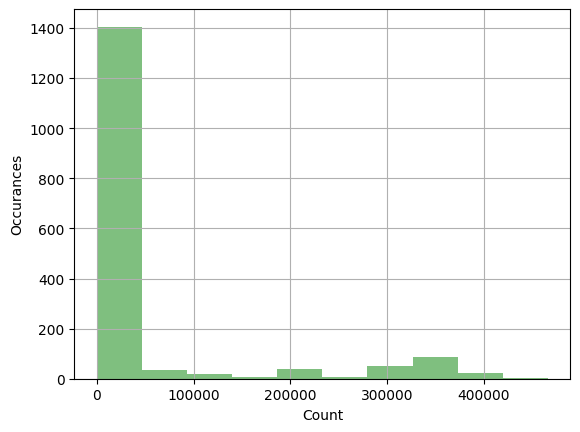

In [73]:
summary = pd.read_csv('summary.csv')
plt.hist(summary['Cnt'].values, 10, facecolor='g', alpha=0.50)
plt.xlabel('Count')
plt.ylabel('Occurances')
plt.grid(True)
plt.show()